In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing required libraries

#for reading and plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#for performance evaluation
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

#for feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

#for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')
import string
import re
import pickle


In [ ]:
#loading data 

df = pd.read_csv("/content/drive/MyDrive/DataSets/Amazon Reviews.csv")

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.shape

(568454, 10)

In [ ]:
#Distribution of class present in the data

df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [ ]:
#checking for null values

df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [ ]:
#df[pd.isnull(df).any(axis=1)]

In [ ]:
#looking for duplicate values and treating them

df[df.duplicated(['UserId','ProfileName','Score','Time'])]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,5,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...
426,427,B000G6RYNE,A1Y3XPZK9ZADFW,albinocrow,0,0,4,1334016000,"pretty good, could be better",Glad to find these in a one ounce size but the...
467,468,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0,0,5,1231718400,"Crunchy, salty, sweet...finally, a Superbowl s...",These Honey Dijon chips bring a terrific balan...
486,487,B000G6RYNE,A31N6KB160O508,Fran W.,0,0,4,1214006400,Firm quality chip,Just got this order and it is ok. A bit light ...
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
...,...,...,...,...,...,...,...,...,...,...
568411,568412,B0018CLWM4,AUX1HSY8FX55S,DAW,1,1,5,1319500800,Happy Camper,I bought this to try on two registered Maine C...
568412,568413,B0018CLWM4,AVZ2OZ479Q9E8,Ai Ling Chow,0,0,5,1336435200,Two Siberians like it!,When we brought home two 3-month-old purebred ...
568413,568414,B0018CLWM4,AI3Y26HLPYW4L,kimosabe,1,2,2,1330041600,premium edge cat food,My cats don't like it. what else can I say to ...
568440,568441,B005ZC0RRO,A2TO5R8QLIITEF,SAK,1,1,5,1323734400,"Delicious, all natural and allergy free treats!",Indie Candy's gummies are absolutely delicious...


So there are some duplicates


In [ ]:
#dropping duplicates

df.drop_duplicates(inplace=True, subset=['UserId','ProfileName','Score','Time'])

In [ ]:
#shape of data after dropping duplicated values

df.shape

(368093, 10)

In [ ]:
#again checking for null values

df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    3
Text                       0
dtype: int64

Null values data is also dropped after duplicated values dropping

In [ ]:
#dropping null values

total_rows =  df.shape[0]
df.dropna(how='any',inplace=True)
remaining_rows= df.shape[0]

removed_rows = total_rows-remaining_rows
print("No. of rows removed :", removed_rows)


No. of rows removed : 14


In [ ]:
#Removing Noise 

df = df[df['HelpfulnessNumerator']<=df['HelpfulnessDenominator']]

In [ ]:
#final dataframe shape after de-duplication, null-values treatment and removing noise

df.shape

(368077, 10)

In [ ]:
#renaming sentiment score with positive and negative

def renaming_score(x):
    
    return "Positive" if x>=3 else "Negative"

df.loc[:, 'sentiment'] = df.Score.apply(renaming_score)

In [ ]:
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive


In [ ]:
#looking for class distribution

df['sentiment'].value_counts()

Positive    312340
Negative     55737
Name: sentiment, dtype: int64

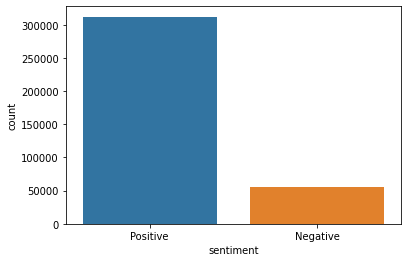

In [ ]:
sns.countplot(data=df,x='sentiment')

In [ ]:
#df1 will be used with class imbalance

df1 = df.copy()

In [ ]:
#downsampling the classes taking 40000 random samples of each

positive = df.loc[df.sentiment=="Positive"].sample(40000)

negative = df.loc[df.sentiment=="Negative"].sample(40000)

df = pd.concat([positive, negative])
df.shape

(80000, 11)

In [ ]:
#modifying stopwords vocabolary

import nltk
nltk.download('stopwords')
total_stopwords = set(stopwords.words('english'))

# subtract negative stop words like no, not, don't etc.. from total_stopwords
negative_stop_words = set(word for word in total_stopwords 
                          if "n't" in word or 'no' in word or "n'" in word)

final_stopwords = total_stopwords - negative_stop_words


#final_stopwords.add("one")
print(final_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
{'she', 'll', 'being', 'than', 'too', 'few', 'what', 'himself', 'we', 'or', 'can', 'same', 'did', 'hadn', 'herself', 'the', 'each', 'further', 'i', 'who', 'yourself', 's', 'won', 'between', 'some', 'doing', 'didn', 'needn', 'below', 'shan', 'your', 'down', 'it', 'other', 'once', 'hasn', 'yourselves', "you'll", "you've", 'with', 'does', 'above', 'their', 've', 'to', 'has', 'isn', 'theirs', 'been', 'why', 'me', 'couldn', 'our', 'm', 'about', 'those', 'by', 'myself', 'were', 't', 'him', 'are', 'an', 'off', 'should', 'y', 'and', 'his', 'hers', 'such', 'then', 'mustn', 'after', 'most', 'he', 'mightn', "that'll", 'for', 'ain', 'again', 'only', 'into', 'shouldn', 'a', 'weren', 'whom', 'them', "it's", 'on', 'wouldn', 'was', 'in', "you're", 'itself', 'out', 'ourselves', 'these', 'have', 'how', 'be', 'you', "should've", 're', 'her', 'my', 'as', 'own', 'where', 'so', 'while', 'having', '

In [ ]:
import re
import nltk

#from nltk.corpus import stopwords
stop = final_stopwords

#initialising the snowball stemmer
sno = nltk.stem.SnowballStemmer('english')                      

#function to clean the word of any html-tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#function to clean the word of any punctuation or special characters
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


#function to text summarization
def final_sentence(text):
    
    text = text.split()
    text = [cleanhtml(x) for x in text]
    text = [cleanpunc(x) for x in text]
    
    def test(word):
        if word.isalpha() and len(word) > 2 and word.lower() not in stop:
            s=(sno.stem(word.lower()))
            return s
        else:
            pass
    text = [test(x) for x in text if test(x)]
    
    return ' '.join(text)

In [ ]:
from tqdm import tqdm
tqdm.pandas()

df['CleanedText'] = df['Text'].progress_apply(final_sentence)
df1['CleanedText'] = df1['Text'].progress_apply(final_sentence)
print(df.shape)
print(df1.shape)
#df.head()

100%|██████████| 368077/368077 [09:41<00:00, 632.83it/s]


(80000, 12)
(368077, 12)


In [ ]:
df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment,CleanedText
96732,96733,B001ELL4F4,AD1QYPQT28F0U,P. Contino,8,8,5,1195171200,best cup of regular,"If you like a bolder coffee with rich flavor, ...",Positive,like bolder coffe rich not bitter burnt full f...


In [ ]:
df1.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,sentiment,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,Positive,bought sever vital can dog food product found ...


In [ ]:
# #word cloud

# from wordcloud import WordCloud, STOPWORDS

In [ ]:
# def generate_wcloud(text):
    
    
#     wordcloud = WordCloud(background_color='white')
#     wordcloud.generate(text)
    
#     plt.figure(figsize=(15,7))
#     plt.axis('off')
#     plt.imshow(wordcloud, interpolation='bilinear')
#     return plt.show()

In [ ]:
####Positive Reviews

In [ ]:
# pos = df.loc[df.sentiment=="Positive"].Text
# text = " ".join(review for review in pos.astype(str))

# generate_wcloud(text)

In [ ]:
###Negative Reviews

In [ ]:
# pos = df.loc[df.sentiment=="Negative"].Text
# text = " ".join(review for review in pos.astype(str))

# generate_wcloud(text)

In [ ]:
###Neutral Reviews

In [ ]:
# pos = df.loc[df.sentiment=="Neutral"].Text
# text = " ".join(review for review in pos.astype(str))

# generate_wcloud(text)

In [ ]:
from sklearn.model_selection import train_test_split
X = df.CleanedText
y = df.sentiment

X1 = df1.CleanedText
y1 = df1.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.20)


In [ ]:
X_train.shape, X_test.shape


((64000,), (16000,))

In [ ]:
X1_train.shape, X1_test.shape


((294461,), (73616,))

In [ ]:
y1_test.shape

(73616,)

In [ ]:
# Implementing Bag Of Words
bow_vectorizer = CountVectorizer(max_features=10000)
bow_vectorizer1 = CountVectorizer(max_features=10000)
bow_vectorizer.fit(X_train)
bow_vectorizer1.fit(X1_train)
# transformation
bow_X_train = bow_vectorizer.transform(X_train)
bow_X_test = bow_vectorizer.transform(X_test)
bow_X1_train = bow_vectorizer1.transform(X1_train)
bow_X1_test = bow_vectorizer1.transform(X1_test)

In [ ]:
bow_vectorizer.vocabulary_

{'dog': 2557,
 'love': 5084,
 'not': 5887,
 'stand': 8294,
 'jerki': 4570,
 'best': 746,
 'ive': 4524,
 'ever': 2960,
 'great': 3772,
 'also': 245,
 'appl': 358,
 'slice': 7957,
 'time': 8932,
 'wish': 9804,
 'could': 1962,
 'find': 3207,
 'local': 5038,
 'chain': 1389,
 'seem': 7671,
 'carri': 1284,
 'sever': 7733,
 'worth': 9847,
 'send': 7693,
 'get': 3573,
 'dont': 2577,
 'want': 9609,
 'tag': 8661,
 'amazon': 264,
 'there': 8841,
 'run': 7447,
 'might': 5451,
 'avail': 510,
 'next': 5816,
 'especi': 2922,
 'coffe': 1701,
 'provid': 6854,
 'aromat': 402,
 'scent': 7601,
 'air': 164,
 'brew': 1013,
 'fresh': 3416,
 'well': 9684,
 'ground': 3814,
 'size': 7912,
 'nice': 5822,
 'make': 5175,
 'cup': 2102,
 'flavor': 3255,
 'bit': 813,
 'lighter': 4970,
 'side': 7853,
 'may': 5312,
 'favorit': 3127,
 'your': 9937,
 'realli': 7058,
 'dark': 2174,
 'wolfgang': 9818,
 'puck': 6869,
 'sign': 7861,
 'recip': 7085,
 'wooden': 9828,
 'tongu': 8984,
 'doctor': 2550,
 'offic': 5997,
 'thin': 88

In [ ]:
# transformation using tf-idf
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
tfidf_vectorizer.fit(X_train)

# transform
tfidf_X_train = tfidf_vectorizer.transform(X_train)
tfidf_X_test = tfidf_vectorizer.transform(X_test)
tfidf_X1_train = tfidf_vectorizer.transform(X1_train)
tfidf_X1_test = tfidf_vectorizer.transform(X1_test)

In [ ]:
tfidf_vectorizer.vocabulary_

{'dog': 2557,
 'love': 5084,
 'not': 5887,
 'stand': 8294,
 'jerki': 4570,
 'best': 746,
 'ive': 4524,
 'ever': 2960,
 'great': 3772,
 'also': 245,
 'appl': 358,
 'slice': 7957,
 'time': 8932,
 'wish': 9804,
 'could': 1962,
 'find': 3207,
 'local': 5038,
 'chain': 1389,
 'seem': 7671,
 'carri': 1284,
 'sever': 7733,
 'worth': 9847,
 'send': 7693,
 'get': 3573,
 'dont': 2577,
 'want': 9609,
 'tag': 8661,
 'amazon': 264,
 'there': 8841,
 'run': 7447,
 'might': 5451,
 'avail': 510,
 'next': 5816,
 'especi': 2922,
 'coffe': 1701,
 'provid': 6854,
 'aromat': 402,
 'scent': 7601,
 'air': 164,
 'brew': 1013,
 'fresh': 3416,
 'well': 9684,
 'ground': 3814,
 'size': 7912,
 'nice': 5822,
 'make': 5175,
 'cup': 2102,
 'flavor': 3255,
 'bit': 813,
 'lighter': 4970,
 'side': 7853,
 'may': 5312,
 'favorit': 3127,
 'your': 9937,
 'realli': 7058,
 'dark': 2174,
 'wolfgang': 9818,
 'puck': 6869,
 'sign': 7861,
 'recip': 7085,
 'wooden': 9828,
 'tongu': 8984,
 'doctor': 2550,
 'offic': 5997,
 'thin': 88

In [ ]:
# Defining model for future

def train_and_eval(model, trainX, trainY, testX, testY):

    # training
    _ = model.fit(trainX, trainY)

    # predictions
    y_preds_train = model.predict(trainX)
    y_preds_test = model.predict(testX)

    # evaluation
    print()
    print(model)
    print(f"Train accuracy score : {accuracy_score(trainY, y_preds_train)}")
    print(f"Test accuracy score : {accuracy_score(testY, y_preds_test)}")
    print(classification_report(testY, y_preds_test))
    print('\n',40*'-')

In [ ]:
# Logistic Regression with BoW

In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=bow_X_train,
                   trainY=y_train,
                   testX=bow_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train accuracy score : 0.80684375
Test accuracy score : 0.802375
              precision    recall  f1-score   support

    Negative       0.81      0.80      0.80      8000
    Positive       0.80      0.81      0.80      8000

    accuracy                           0.80     16000
   macro avg       0.80      0.80      0.80     16000
weighted avg       0.80      0.80      0.80     16000


 ----------------------------------------

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random

In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C:
  log_model = LogisticRegression(C=c, max_iter=500)
  # Train and evaluate model
  train_and_eval(model=log_model,
                   trainX=bow_X1_train,
                   trainY=y1_train,
                   testX=bow_X1_test,
                   testY=y1_test)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train accuracy score : 0.8726011254461542
Test accuracy score : 0.8702591827863508
              precision    recall  f1-score   support

    Negative       0.76      0.22      0.34     11274
    Positive       0.88      0.99      0.93     62342

    accuracy                           0.87     73616
   macro avg       0.82      0.60      0.64     73616
weighted avg       0.86      0.87      0.84     73616


 ----------------------------------------

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
    

In [ ]:
# Naive Bayes Classifier with BoW 

In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model=nb_model,
                   trainX=bow_X1_train,
                   trainY=y1_train,
                   testX=bow_X1_test,
                   testY=y1_test)


MultinomialNB(alpha=0, class_prior=None, fit_prior=True)
Train accuracy score : 0.8839744482291373
Test accuracy score : 0.8779205607476636
              precision    recall  f1-score   support

    Negative       0.60      0.63      0.61     11274
    Positive       0.93      0.92      0.93     62342

    accuracy                           0.88     73616
   macro avg       0.76      0.78      0.77     73616
weighted avg       0.88      0.88      0.88     73616


 ----------------------------------------

MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)
Train accuracy score : 0.8833088252773712
Test accuracy score : 0.8778933927407085
              precision    recall  f1-score   support

    Negative       0.60      0.63      0.61     11274
    Positive       0.93      0.92      0.93     62342

    accuracy                           0.88     73616
   macro avg       0.76      0.78      0.77     73616
weighted avg       0.88      0.88      0.88     73616


 -----------------

In [ ]:
# Logistic Regression with Tf-Idf¶

In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train accuracy score : 0.794578125
Test accuracy score : 0.788

 ----------------------------------------

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train accuracy score : 0.809734375
Test accuracy score : 0.8035

 ----------------------------------------

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max

In [ ]:
# Hyperparameters
C = [0.001, 0.01, 0.1, 1, 10]

for c in C: 
    # Define model
    log_model = LogisticRegression(C=c, max_iter=500, random_state=1)
    
    # Train and evaluate model
    train_and_eval(model=log_model,
                   trainX=tfidf_X1_train,
                   trainY=y1_train,
                   testX=tfidf_X1_test,
                   testY=y1_test)


LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Train accuracy score : 0.8490020749776711
Test accuracy score : 0.8468539447946098
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     11274
    Positive       0.85      1.00      0.92     62342

    accuracy                           0.85     73616
   macro avg       0.42      0.50      0.46     73616
weighted avg       0.72      0.85      0.78     73616


 ----------------------------------------

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
       

In [ ]:
# Naive Bayes classifier with Tf-Idf

In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model= nb_model,
                   trainX=tfidf_X_train,
                   trainY=y_train,
                   testX=tfidf_X_test,
                   testY=y_test)


MultinomialNB(alpha=0, class_prior=None, fit_prior=True)
Train accuracy score : 0.84484375
Test accuracy score : 0.810625
              precision    recall  f1-score   support

    Negative       0.82      0.80      0.81      8000
    Positive       0.80      0.82      0.81      8000

    accuracy                           0.81     16000
   macro avg       0.81      0.81      0.81     16000
weighted avg       0.81      0.81      0.81     16000


 ----------------------------------------

MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)
Train accuracy score : 0.843484375
Test accuracy score : 0.8159375
              precision    recall  f1-score   support

    Negative       0.82      0.80      0.81      8000
    Positive       0.81      0.83      0.82      8000

    accuracy                           0.82     16000
   macro avg       0.82      0.82      0.82     16000
weighted avg       0.82      0.82      0.82     16000


 ----------------------------------------

Multinomi

In [ ]:
alphas = [0, 0.2, 0.6, 0.8, 1]

for a  in alphas: 
    # Define model
    nb_model = MultinomialNB(alpha=a)

    # Train and evaluate model
    train_and_eval(model= nb_model,
                   trainX=tfidf_X1_train,
                   trainY=y1_train,
                   testX=tfidf_X1_test,
                   testY=y1_test)


MultinomialNB(alpha=0, class_prior=None, fit_prior=True)
Train accuracy score : 0.8700778710932857
Test accuracy score : 0.865205933492719
              precision    recall  f1-score   support

    Negative       0.85      0.15      0.25     11274
    Positive       0.87      1.00      0.93     62342

    accuracy                           0.87     73616
   macro avg       0.86      0.57      0.59     73616
weighted avg       0.86      0.87      0.82     73616


 ----------------------------------------

MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)
Train accuracy score : 0.8695209212765018
Test accuracy score : 0.8651923494892415
              precision    recall  f1-score   support

    Negative       0.86      0.14      0.25     11274
    Positive       0.87      1.00      0.93     62342

    accuracy                           0.87     73616
   macro avg       0.86      0.57      0.59     73616
weighted avg       0.86      0.87      0.82     73616


 ------------------

In [ ]:
# Logistic Regression with tf-idf is the best model with 84.09% accuracy with c = 1

In [ ]:
### Cross Validation logistic regression with Bow
a = np.random.normal(loc = 0 , scale = 0.1,size = 50)
param_distb =  {'C': [b for b in a if b >0  ]}
print(param_distb)


{'C': [0.008348991424093604, 0.18773416426337752, 0.04776982041916623, 0.16683498279972953, 0.024367940612964867, 0.003235191084982228, 0.04483750504964624, 0.13116866448228767, 0.10474107580009939, 0.15154551077290634, 0.14458324875187442, 0.012852975637659594, 0.02895227690208771, 0.009447350873815897, 0.07527775407161082, 0.029869614129635493, 0.17668661559352922, 0.09305752491225072, 0.04268444337179101, 0.17043274883390366, 0.03103021317367809, 0.15440791296659598, 0.08005796362600233, 0.054528156807573225]}


In [ ]:
model_random = RandomizedSearchCV(LogisticRegression(),param_distb,cv = 10 ,scoring = 'accuracy')
model_random.fit(bow_X_train,y_train)
print(model_random.best_estimator_)
pred = model_random.predict(bow_X_test)
print('Accuracy',accuracy_score(y_test,pred)*100)
print(classification_report(y_test,pred))

LogisticRegression(C=0.09305752491225072, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy 83.49375
              precision    recall  f1-score   support

    Negative       0.84      0.83      0.83      8000
    Positive       0.83      0.84      0.84      8000

    accuracy                           0.83     16000
   macro avg       0.83      0.83      0.83     16000
weighted avg       0.83      0.83      0.83     16000



In [ ]:
model_random = RandomizedSearchCV(LogisticRegression(),param_distb,cv = 10 ,scoring = 'accuracy')
model_random.fit(bow_X1_train,y1_train)
print(model_random.best_estimator_)
pred = model_random.predict(bow_X1_test)
print('Accuracy',accuracy_score(y1_test,pred)*100)
print(classification_report(y1_test, pred))

LogisticRegression(C=0.18773416426337752, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy 89.59872853727451
              precision    recall  f1-score   support

    Negative       0.74      0.49      0.59     11274
    Positive       0.91      0.97      0.94     62342

    accuracy                           0.90     73616
   macro avg       0.83      0.73      0.77     73616
weighted avg       0.89      0.90      0.89     73616



In [ ]:
def plot_cm(y_true, y_pred):
    plt.figure(figsize=(6,6))
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    
    sns.heatmap(
        cm, annot=True, cmap='Blues', cbar=False, fmt='.2f',
        xticklabels=labels, yticklabels=labels)
    
    return plt.show()

In [ ]:
  plot_cm(y1_test, pred)

NameError: ignored

<Figure size 432x432 with 0 Axes>

In [ ]:
param_grid = {'n_estimators': [8, 16, 32, 64, 100, 200],'max_depth': [2, 5, 7, 9]}
gd = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'),param_grid,cv = 5,scoring = 'accuracy')
gd.fit(bow_X_train,y_train)
print(gd.best_estimator_)
pred = gd.predict(bow_X_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy is 78.825


In [ ]:
para_grid = {'n_estimators': [8, 16, 32, 64, 100, 200],'max_depth': [10,20]}
ggd = GridSearchCV(GradientBoostingClassifier(),para_grid,cv = 5,scoring = 'accuracy')
ggd.fit(bow_X_train,y_train)
print(ggd.best_estimator_)
pred = ggd.predict(bow_X_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

KeyboardInterrupt: ignored

In [ ]:
plot_cm(y_test, pred)

In [ ]:
param_grid = {'n_estimators': [8, 16, 32, 64, 100, 200],'max_depth': [2, 5, 7, 9]}
gd = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'),param_grid,cv = 5,scoring = 'accuracy')
gd.fit(tfidf_X_train,y_train)
print(gd.best_estimator_)
pred = gd.predict(tfidf_X_test)
acc = accuracy_score(y_test,pred)
print('Accuracy is',acc*100)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy is 79.3625


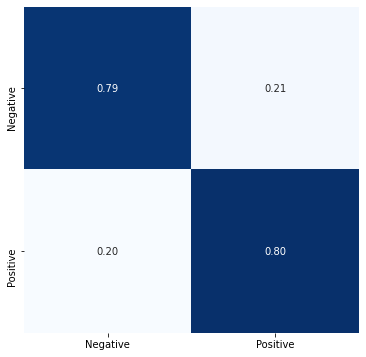

In [ ]:
plot_cm(y_test, pred)